In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='c01d1950-64ed-458a-8769-d09eb4915f38', project_access_token='p-6687e1ad774fb6f47d4237e8f91043563f34de29')
pc = project.project_context


In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

# import sys
# !{sys.executable} -m pip install BeautifulSoup4
from bs4 import BeautifulSoup

import sys
!{sys.executable} -m pip install requests

import sys
!{sys.executable} -m pip install html5lib

import sys
!{sys.executable} -m pip install lxml

import sys
!{sys.executable} -m pip install folium

     |████████████████████████████████| 92kB 9.6MB/s  eta 0:00:01


In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot')

In [4]:
import random # library for random number generation
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize
import json # library to handle JSON files
import folium # plotting library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans


In [6]:
CLIENT_ID = '4WO4KRUANXC4FNWIUGCJ0HHDBEOMWGNNJD3NMGRJETF53GCH' # your Foursquare ID
CLIENT_SECRET = 'I0WW4EUGZIR4K4SRP2LB3TYQNQJBO2NC4MU5OM53FD10GHNX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 4WO4KRUANXC4FNWIUGCJ0HHDBEOMWGNNJD3NMGRJETF53GCH
CLIENT_SECRET:I0WW4EUGZIR4K4SRP2LB3TYQNQJBO2NC4MU5OM53FD10GHNX


## Get Neighborhood of Toronto

In [7]:
#create requests
source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

#create beautifulsoup
soup = BeautifulSoup(source, 'html5lib')

#scrape the table 
body = soup.find('body')
content = body.find('div', id = 'content')
bodyContent = content.find('div', id = 'bodyContent')
mw_content_text = bodyContent.find('div', id = 'mw-content-text')
mw_parser_output = mw_content_text.find('div', class_= 'mw-parser-output')
table_sorter = mw_parser_output.find('table', class_='wikitable sortable')

#pandas read html (result = list)
dfs = pd.read_html(str(table_sorter), header = 0)

#list to Dataframe
df = dfs[0]

df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [8]:
#change column header
header = ['PostalCode', 'Borough', 'Neighborhood']
df.columns = header

#raplace "Not assigned" with NaN for easy droping 
df.replace(to_replace = 'Not assigned', value  = pd.np.nan, inplace = True)

#drop rows if Borough = NaN
df.dropna(subset = ['Borough'],inplace = True)
df.reset_index(drop = True, inplace = True)

#replace all (Neighborhood = NaN) to its Borough name
index_null = df.index[np.nonzero(pd.isnull(df.values).any(1))]
for index in index_null:
	df.iloc[index, df.columns.get_loc('Neighborhood')] = df.iloc[index, df.columns.get_loc('Borough')]

#group Postalcode and add Neighborhood with the same Postalcode together
df_group = df.groupby(['PostalCode','Borough'], sort = False)['Neighborhood'].apply(', '.join).reset_index()

df_group.head(20)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park,Queen's Park
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Rouge, Malvern"
7,M3B,North York,Don Mills North
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


In [9]:
df_group.shape

(103, 3)

In [10]:
!wget -q -O 'toronto_data.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')
df_data = pd.read_csv('toronto_data.csv')
df_data.head()

Data downloaded!


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [51]:
header1 = ['PostalCode', 'Latitude','Longitude']
df_data.columns = header1
df_toronto = df_group.set_index('PostalCode').join(df_data.set_index('PostalCode')).reset_index()

df_toronto.head()


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [12]:
address = 'Toronto, Ontario, Canada'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [13]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, df_toronto in zip(df_toronto['Latitude'], df_toronto['Longitude'], df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(df_toronto, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Find Venue for Each Neighborhood

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip( names, latitudes, longitudes):
        
     
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
       
        results = requests.get(url).json()["response"]['groups'][0]['items']
#         results = requests.get(url).json()
        #print(results)
         # return only relevant information for each nearby venue
        venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['id'], 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])
        
        
        
       
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    headername = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID', 
                  'Venue',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    nearby_venues.columns = headername
       
        
    return(nearby_venues)

In [ ]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

In [ ]:
print(toronto_venues.shape)
toronto_venues.head()

In [1]:

project.save_data(data=torento_venues.to_csv(index=False),file_name='torento_venues.csv',overwrite=True)


In [15]:
toronto_venues = pd.read_csv(project.get_file('toronto_venues.csv'))

In [16]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,4b8991cbf964a520814232e3,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,4bd4846a6798ef3bd0c5618d,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,Parkwoods,43.753259,-79.329656,4e8d9dcdd5fbbbb6b3003c7b,Brookbanks Park,43.751976,-79.332140,Park
3,Parkwoods,43.753259,-79.329656,4bdccf4cafe8c9b6da285185,LCBO,43.757774,-79.314257,Liquor Store
4,Parkwoods,43.753259,-79.329656,58a8dcaa6119f47b9a94dc05,A&W Canada,43.760643,-79.326865,Fast Food Restaurant


 Result is Neighborhood, Lat, Long, Venue ID, Name, Lat, Long, Category

## Use data that only contains Restaurant

In [17]:
toronto_restaurant = toronto_venues[toronto_venues['Venue Category'].str.contains("Restaurant") == True].reset_index(drop=True)
print(toronto_restaurant.shape)
toronto_restaurant.head(9)

(1695, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,4b8991cbf964a520814232e3,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,58a8dcaa6119f47b9a94dc05,A&W Canada,43.760643,-79.326865,Fast Food Restaurant
2,Parkwoods,43.753259,-79.329656,4bc9d0bb511f9521c044aec7,McDonald's,43.758048,-79.313242,Fast Food Restaurant
3,Victoria Village,43.725882,-79.315572,4b9bccbef964a520ae2636e3,Sultan Of Samosas,43.718823,-79.304350,Indian Restaurant
4,Victoria Village,43.725882,-79.315572,4aec8a50f964a5207ac821e3,Armenian Kitchen,43.731071,-79.305390,Middle Eastern Restaurant
5,Victoria Village,43.725882,-79.315572,550df684498ea2dd2c87bb5a,Jatujak,43.736208,-79.307668,Thai Restaurant
6,Victoria Village,43.725882,-79.315572,54af5f6f498e16775481c791,Diwan,43.725002,-79.332019,Middle Eastern Restaurant
7,Victoria Village,43.725882,-79.315572,4c223c519a67a5931124dc87,Shirin Kebab House,43.725503,-79.298132,Middle Eastern Restaurant
8,Victoria Village,43.725882,-79.315572,4f3ecce6e4b0587016b6f30d,Portugril,43.725819,-79.312785,Portuguese Restaurant


## visual data

### All restaurant data

In [18]:
toronto_restaurant_count = toronto_restaurant.groupby(['Neighborhood']).count().reset_index()
toronto_restaurant_count = toronto_restaurant_count[['Neighborhood','Venue']]
toronto_restaurant_count.columns = ['Neighborhood','Restaurant Count']
toronto_restaurant_count.sort_values(by ='Restaurant Count' ,ascending = False, inplace=True)
toronto_restaurant_count.set_index('Neighborhood',inplace = True)
print(toronto_restaurant_count.shape)
toronto_restaurant_count.head()

(102, 1)


,Restaurant Count
Neighborhood,
Willowdale South,35
"Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West",32
"Harbord, University of Toronto",31
Rosedale,31
"The Annex, North Midtown, Yorkville",31


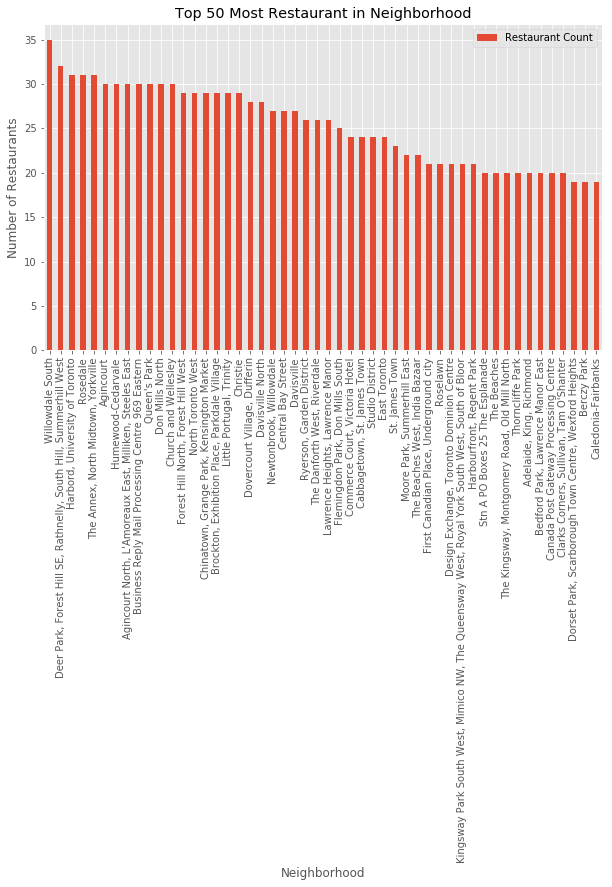

In [19]:

toronto_restaurant_count.head(50).plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Restaurants') # add y-label to the plot
plt.title('Top 50 Most Restaurant in Neighborhood') # add title to the plot

plt.show()

### Japanese data

In [20]:
toronto_japanese_restaurant = toronto_restaurant[toronto_restaurant["Venue Category"].str.contains("Japan") == True].reset_index(drop=True)
toronto_japanese_restaurant.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Harbourfront, Regent Park",43.654260,-79.360636,574ad72238fa943556d93b8e,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant
1,Queen's Park,43.662301,-79.389494,4b2bd898f964a52042bc24e3,Kinka Izakaya Original,43.660596,-79.378891,Japanese Restaurant
2,Queen's Park,43.662301,-79.389494,4ad4c05ff964a5203af720e3,Yamato Japanese Restaurant,43.670683,-79.391056,Japanese Restaurant
3,Queen's Park,43.662301,-79.389494,4ad9f607f964a520691c21e3,Manpuku まんぷく,43.653612,-79.390613,Japanese Restaurant
4,Queen's Park,43.662301,-79.389494,5773f01f498e98371390bdfd,Rolltation,43.654918,-79.387424,Japanese Restaurant


In [21]:
toronto_japanese_restaurant_count = toronto_japanese_restaurant.groupby(['Neighborhood']).count().reset_index()
toronto_japanese_restaurant_count = toronto_japanese_restaurant_count[['Neighborhood','Venue']]
toronto_japanese_restaurant_count.columns = ['Neighborhood','Japanese Restaurant Count']
toronto_japanese_restaurant_count.sort_values(by ='Japanese Restaurant Count' ,ascending = False, inplace=True)
toronto_japanese_restaurant_count.set_index('Neighborhood',inplace = True)
print(toronto_japanese_restaurant_count.shape)
toronto_japanese_restaurant_count.head()

(57, 1)


,Japanese Restaurant Count
Neighborhood,
Don Mills North,6
Queen's Park,5
"Cabbagetown, St. James Town",4
"Flemingdon Park, Don Mills South",4
York Mills West,4


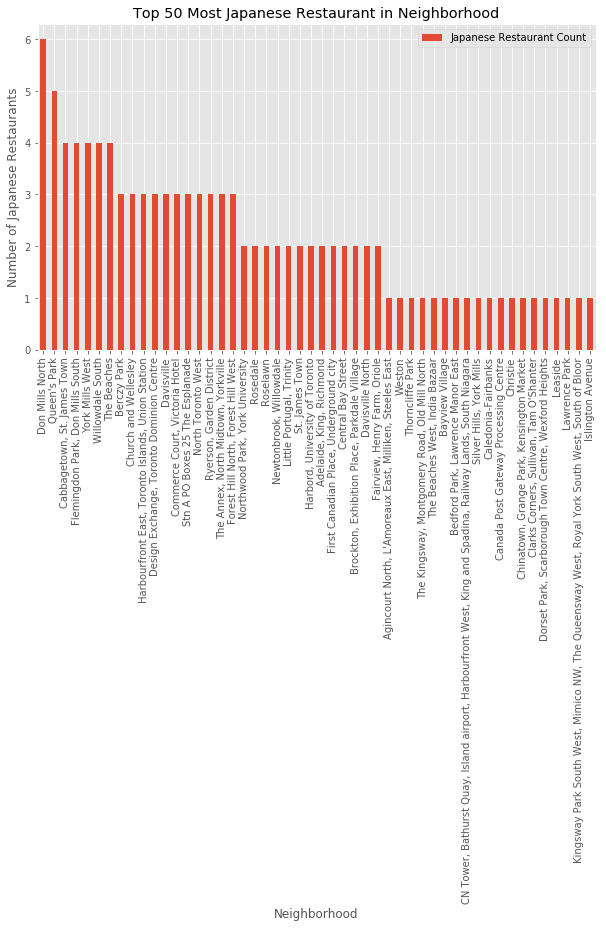

In [22]:
toronto_japanese_restaurant_count.head(50).plot(kind='bar', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of Japanese Restaurants') # add y-label to the plot
plt.title('Top 50 Most Japanese Restaurant in Neighborhood') # add title to the plot

plt.show()

In [23]:
toronto_merged = toronto_restaurant_count.join(toronto_japanese_restaurant_count, on = 'Neighborhood')

toronto_merged.sort_values(by = ['Restaurant Count','Japanese Restaurant Count'],ascending = False, inplace=True)
toronto_merged.head()

,Restaurant Count,Japanese Restaurant Count
Neighborhood,,
Willowdale South,35,4.0
"Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West",32,NaN
"The Annex, North Midtown, Yorkville",31,3.0
"Harbord, University of Toronto",31,2.0
Rosedale,31,2.0


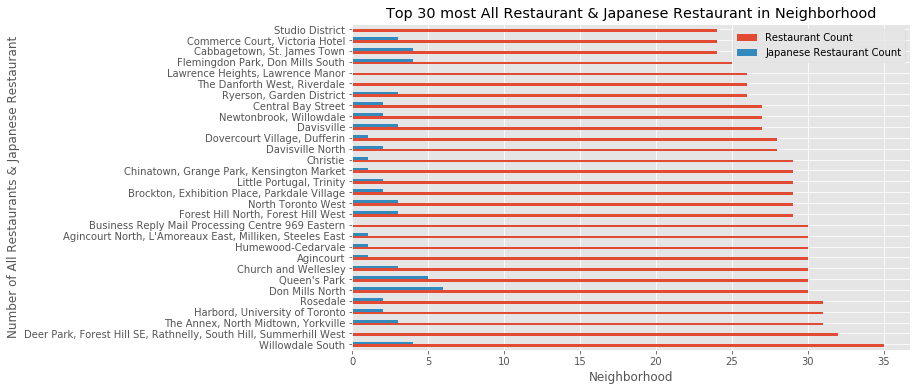

In [24]:
toronto_merged.head(30).plot(kind='barh', figsize=(10, 6))

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of All Restaurants & Japanese Restaurant') # add y-label to the plot
plt.title('Top 30 most All Restaurant & Japanese Restaurant in Neighborhood') # add title to the plot

plt.show()

## Request Likes

In [26]:
def getVenuesLikes(venues_id, names):
    
    venues_list=[]
    for venue_id, name in zip( venues_id, names):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID,
            CLIENT_SECRET, 
            VERSION)
            
        # make the GET request
       
        results = requests.get(url).json()["response"]["likes"]["count"]
        #results = requests.get(url).json()
        #print(results)
         # return only relevant information for each nearby venue
        venues_list.append([
        venue_id, 
        name,  
        results])
        #print(venues_list)
        
        
       
    likes_venues = pd.DataFrame(venues_list)
    headername = ['Venue ID', 
                  'Venue',
                  'likes']
    likes_venues.columns = headername
       
        
    return(likes_venues)

In [ ]:
venues_likes = getVenuesLikes(venues_id = toronto_restaurant['Venue ID'],
                                   names =toronto_restaurant['Venue'],
                                  )

In [76]:
venues_likes.head(20)

,Venue ID,Venue,likes
0,4b8991cbf964a520814232e3,Allwyn's Bakery,17
1,58a8dcaa6119f47b9a94dc05,A&W Canada,5
2,4bc9d0bb511f9521c044aec7,McDonald's,14
3,4b9bccbef964a520ae2636e3,Sultan Of Samosas,29
4,4aec8a50f964a5207ac821e3,Armenian Kitchen,21
5,550df684498ea2dd2c87bb5a,Jatujak,30
6,54af5f6f498e16775481c791,Diwan,13
7,4c223c519a67a5931124dc87,Shirin Kebab House,19
8,4f3ecce6e4b0587016b6f30d,Portugril,5
9,4b7c9784f964a520b29c2fe3,KFC,1


In [78]:

project.save_data(data=venues_likes.to_csv(index=False),file_name='venues_likes.csv',overwrite=True)


In [27]:
venues_likes = pd.read_csv(project.get_file('venues_likes.csv'))

In [28]:
venues_likes.head()

,Venue ID,Venue,likes
0,4b8991cbf964a520814232e3,Allwyn's Bakery,17
1,58a8dcaa6119f47b9a94dc05,A&W Canada,5
2,4bc9d0bb511f9521c044aec7,McDonald's,14
3,4b9bccbef964a520ae2636e3,Sultan Of Samosas,29
4,4aec8a50f964a5207ac821e3,Armenian Kitchen,21


In [29]:
venues_likes.shape

(1695, 3)

In [30]:
venues_likes.drop('Venue',axis = 1 ,inplace=True)
venues_likes.head()

,Venue ID,likes
0,4b8991cbf964a520814232e3,17
1,58a8dcaa6119f47b9a94dc05,5
2,4bc9d0bb511f9521c044aec7,14
3,4b9bccbef964a520ae2636e3,29
4,4aec8a50f964a5207ac821e3,21


Now we have likes from each venue

In [31]:
venues_likes_merged = toronto_restaurant.set_index('Venue ID').join(venues_likes.set_index('Venue ID')).reset_index()
venues_likes_merged.head()

,Venue ID,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,likes
0,4a72360ef964a52098da1fe3,Church and Wellesley,43.665860,-79.383160,Ethiopian House,43.666599,-79.385669,Ethiopian Restaurant,48
1,4a8355bff964a520d3fa1fe3,Queen's Park,43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant,55
2,4a8355bff964a520d3fa1fe3,Queen's Park,43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant,55
3,4a8355bff964a520d3fa1fe3,Queen's Park,43.662301,-79.389494,Mercatto,43.660391,-79.387664,Italian Restaurant,55
4,4a8355bff964a520d3fa1fe3,"Ryerson, Garden District",43.657162,-79.378937,Mercatto,43.660391,-79.387664,Italian Restaurant,55


In [32]:
venues_likes_merged_mean = venues_likes_merged.groupby(['Neighborhood']).mean().reset_index()
venues_likes_merged_mean = venues_likes_merged_mean[['Neighborhood','likes']]
venues_likes_merged_mean.columns = ['Neighborhood','All Restaurant Likes']
venues_likes_merged_mean.sort_values(by ='All Restaurant Likes' ,ascending = False, inplace=True)
venues_likes_merged_mean.set_index('Neighborhood',inplace = True)
print(venues_likes_merged_mean.shape)
venues_likes_merged_mean.head()

(102, 1)


,All Restaurant Likes
Neighborhood,
"Harbourfront East, Toronto Islands, Union Station",166.928571
"Adelaide, King, Richmond",164.171875
Central Bay Street,162.962121
"Design Exchange, Toronto Dominion Centre",156.090909
"First Canadian Place, Underground city",152.143836


In [33]:
japanese_likes_merged = venues_likes_merged[venues_likes_merged["Venue Category"].str.contains("Japan") == True].reset_index(drop=True)
japanese_likes_merged.head()

,Venue ID,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,likes
0,4ad4c05df964a52048f620e3,The Beaches,43.676357,-79.293031,Aki Da Japanese Seafood House,43.669051,-79.304499,Japanese Restaurant,5
1,4ad4c05df964a52048f620e3,The Beaches,43.676357,-79.293031,Aki Da Japanese Seafood House,43.669051,-79.304499,Japanese Restaurant,5
2,4ad4c05df964a52048f620e3,"The Beaches West, India Bazaar",43.668999,-79.315572,Aki Da Japanese Seafood House,43.669051,-79.304499,Japanese Restaurant,5
3,4ad4c05df964a52048f620e3,"The Beaches West, India Bazaar",43.668999,-79.315572,Aki Da Japanese Seafood House,43.669051,-79.304499,Japanese Restaurant,5
4,4ad4c05ff964a5203af720e3,Queen's Park,43.662301,-79.389494,Yamato Japanese Restaurant,43.670683,-79.391056,Japanese Restaurant,65


In [34]:
japanese_likes_merged_mean = japanese_likes_merged.groupby(['Neighborhood']).mean().reset_index()
japanese_likes_merged_mean = japanese_likes_merged_mean[['Neighborhood','likes']]
japanese_likes_merged_mean.columns = ['Neighborhood','Japanese Restaurant Likes']
japanese_likes_merged_mean.sort_values(by ='Japanese Restaurant Likes' ,ascending = False, inplace=True)
japanese_likes_merged_mean.set_index('Neighborhood',inplace = True)
print(japanese_likes_merged_mean.shape)
japanese_likes_merged_mean.head()

(57, 1)


,Japanese Restaurant Likes
Neighborhood,
Central Bay Street,260.222222
"Cabbagetown, St. James Town",234.100000
Church and Wellesley,203.818182
Queen's Park,162.294118
"Ryerson, Garden District",159.062500


In [35]:
toronto_likes_merged = venues_likes_merged_mean.join(japanese_likes_merged_mean, on = 'Neighborhood')

toronto_likes_merged.sort_values(by = ['All Restaurant Likes','Japanese Restaurant Likes'],ascending = False, inplace=True)
toronto_likes_merged.head(10)

,All Restaurant Likes,Japanese Restaurant Likes
Neighborhood,,
"Harbourfront East, Toronto Islands, Union Station",166.928571,104.000000
"Adelaide, King, Richmond",164.171875,60.076923
Central Bay Street,162.962121,260.222222
"Design Exchange, Toronto Dominion Centre",156.090909,81.571429
"First Canadian Place, Underground city",152.143836,63.312500
"Commerce Court, Victoria Hotel",146.092593,81.571429
"Ryerson, Garden District",134.710938,159.062500
Berczy Park,126.844262,81.571429
Stn A PO Boxes 25 The Esplanade,125.877863,81.571429


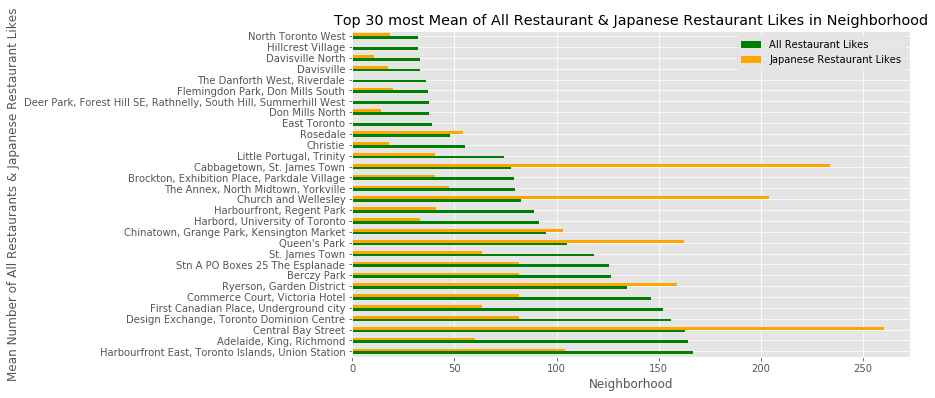

In [36]:
toronto_likes_merged.head(30).plot(kind='barh', figsize=(10, 6), color = ['Green','Orange'])

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Mean Number of All Restaurants & Japanese Restaurant Likes') # add y-label to the plot
plt.title('Top 30 most Mean of All Restaurant & Japanese Restaurant Likes in Neighborhood') # add title to the plot

plt.show()

## Create Only Japanese Restaurant Dataframe

In [37]:
japanese_restaurant = venues_likes_merged[venues_likes_merged["Venue Category"].str.contains("Japan") == True].reset_index(drop=True)
japanese_restaurant.head()

,Venue ID,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,likes
0,4ad4c05df964a52048f620e3,The Beaches,43.676357,-79.293031,Aki Da Japanese Seafood House,43.669051,-79.304499,Japanese Restaurant,5
1,4ad4c05df964a52048f620e3,The Beaches,43.676357,-79.293031,Aki Da Japanese Seafood House,43.669051,-79.304499,Japanese Restaurant,5
2,4ad4c05df964a52048f620e3,"The Beaches West, India Bazaar",43.668999,-79.315572,Aki Da Japanese Seafood House,43.669051,-79.304499,Japanese Restaurant,5
3,4ad4c05df964a52048f620e3,"The Beaches West, India Bazaar",43.668999,-79.315572,Aki Da Japanese Seafood House,43.669051,-79.304499,Japanese Restaurant,5
4,4ad4c05ff964a5203af720e3,Queen's Park,43.662301,-79.389494,Yamato Japanese Restaurant,43.670683,-79.391056,Japanese Restaurant,65


## Group by Mean All restaurant Dataframe

In [38]:
all_restaurant_mean = venues_likes_merged.groupby(['Neighborhood']).mean().reset_index()
print(all_restaurant_mean.shape)
all_restaurant_mean.head()

(102, 6)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,likes
0,"Adelaide, King, Richmond",43.650571,-79.384568,43.650364,-79.382529,164.171875
1,Agincourt,43.794200,-79.262029,43.789712,-79.267321,14.600000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,43.817767,-79.288523,11.400000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437,43.738767,-79.601614,5.857143
4,"Alderwood, Long Branch",43.602414,-79.543484,43.599114,-79.542864,10.000000


In [39]:
all_restaurant_mean.drop(['Neighborhood Latitude'
                                               ,'Neighborhood Longitude'
                                              ,'Venue Latitude'
                                              ,'Venue Longitude']
                                              , axis = 1
                                              , inplace = True)
all_restaurant_mean.columns = ['Neighborhood','All restaurant likes']
all_restaurant_mean.head()

,Neighborhood,All restaurant likes
0,"Adelaide, King, Richmond",164.171875
1,Agincourt,14.600000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",11.400000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",5.857143
4,"Alderwood, Long Branch",10.000000


## Group by Mean Japanese restaurant Dataframe

In [40]:
japanese_restaurant_mean = japanese_restaurant.groupby(['Neighborhood']).mean().reset_index()
print(japanese_restaurant_mean.shape)
japanese_restaurant_mean.head()

(57, 6)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude,likes
0,"Adelaide, King, Richmond",43.650571,-79.384568,43.652096,-79.379836,60.076923
1,Agincourt,43.794200,-79.262029,43.783539,-79.253117,6.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577,43.822372,-79.298905,10.000000
3,Bayview Village,43.786947,-79.385975,43.791613,-79.392267,8.000000
4,"Bedford Park, Lawrence Manor East",43.733283,-79.419750,43.732562,-79.404147,26.000000


In [41]:
japanese_restaurant_mean.drop(['Neighborhood Latitude'
                                               ,'Neighborhood Longitude'
                                              ,'Venue Latitude'
                                              ,'Venue Longitude']
                                              , axis = 1
                                              , inplace = True)
japanese_restaurant_mean.columns = ['Neighborhood','Japanese restaurant likes']
japanese_restaurant_mean.head()

,Neighborhood,Japanese restaurant likes
0,"Adelaide, King, Richmond",60.076923
1,Agincourt,6.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",10.000000
3,Bayview Village,8.000000
4,"Bedford Park, Lawrence Manor East",26.000000


## Merge 2 Dataframe Together

In [42]:
mean_merged = all_restaurant_mean.set_index('Neighborhood').join(japanese_restaurant_mean.set_index('Neighborhood')).reset_index()

In [43]:
mean_merged.head()

,Neighborhood,All restaurant likes,Japanese restaurant likes
0,"Adelaide, King, Richmond",164.171875,60.076923
1,Agincourt,14.600000,6.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",11.400000,10.000000
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",5.857143,NaN
4,"Alderwood, Long Branch",10.000000,NaN


In [44]:
print(mean_merged.shape)
mean_merged.isnull().sum()

(102, 3)


Neighborhood                  0
All restaurant likes          0
Japanese restaurant likes    45
dtype: int64

## Drop null

In [45]:
mean_merged.dropna(axis = 0, inplace = True)

In [46]:
print(mean_merged.shape)
mean_merged.isnull().sum()

(57, 3)


Neighborhood                 0
All restaurant likes         0
Japanese restaurant likes    0
dtype: int64

## K-Mean

In [47]:
# set number of clusters
kclusters = 3

mean_merged_clustering = mean_merged.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(mean_merged_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 0, 2, 2, 0, 1, 0], dtype=int32)

In [48]:
mean_merged.insert(0, 'Cluster Labels', kmeans.labels_)
mean_merged.head()

,Cluster Labels,Neighborhood,All restaurant likes,Japanese restaurant likes
0,2,"Adelaide, King, Richmond",164.171875,60.076923
1,0,Agincourt,14.600000,6.000000
2,0,"Agincourt North, L'Amoreaux East, Milliken, St...",11.400000,10.000000
6,0,Bayview Village,13.800000,8.000000
7,0,"Bedford Park, Lawrence Manor East",10.827586,26.000000


In [52]:

average_likes_merged = df_toronto
average_likes_merged = average_likes_merged.set_index('Neighborhood').join(mean_merged.set_index('Neighborhood')).reset_index()
average_likes_merged.dropna(axis = 0, inplace = True)
average_likes_merged = average_likes_merged.astype({'Cluster Labels':int})
average_likes_merged.head() # check the last columns!

,Neighborhood,PostalCode,Borough,Latitude,Longitude,Cluster Labels,All restaurant likes,Japanese restaurant likes
2,"Harbourfront, Regent Park",M5A,Downtown Toronto,43.654260,-79.360636,2,89.043478,41.000000
4,Queen's Park,M7A,Queen's Park,43.662301,-79.389494,1,104.903846,162.294118
5,Islington Avenue,M9A,Etobicoke,43.667856,-79.532242,0,3.000000,3.000000
7,Don Mills North,M3B,North York,43.745906,-79.352188,0,37.558140,14.000000
9,"Ryerson, Garden District",M5B,Downtown Toronto,43.657162,-79.378937,1,134.710938,159.062500


In [53]:
cluster = average_likes_merged[['Neighborhood', 'Cluster Labels']]
cluster.head()

,Neighborhood,Cluster Labels
2,"Harbourfront, Regent Park",2
4,Queen's Park,1
5,Islington Avenue,0
7,Don Mills North,0
9,"Ryerson, Garden District",1


In [54]:
cluster0 = cluster.loc[cluster['Cluster Labels']==0] 
print(cluster0.shape)
cluster0.head()

(38, 2)


,Neighborhood,Cluster Labels
5,Islington Avenue,0
7,Don Mills North,0
10,Glencairn,0
13,"Flemingdon Park, Don Mills South",0
16,Humewood-Cedarvale,0


In [55]:
cluster1 = cluster.loc[cluster['Cluster Labels']==1] 
print(cluster1.shape)
cluster1.head()

(5, 2)


,Neighborhood,Cluster Labels
4,Queen's Park,1
9,"Ryerson, Garden District",1
24,Central Bay Street,1
96,"Cabbagetown, St. James Town",1
99,Church and Wellesley,1


In [56]:
cluster2 = cluster.loc[cluster['Cluster Labels']==2] 
print(cluster2.shape)
cluster2

(14, 2)


,Neighborhood,Cluster Labels
2,"Harbourfront, Regent Park",2
15,St. James Town,2
20,Berczy Park,2
30,"Adelaide, King, Richmond",2
36,"Harbourfront East, Toronto Islands, Union Station",2
37,"Little Portugal, Trinity",2
42,"Design Exchange, Toronto Dominion Centre",2
43,"Brockton, Exhibition Place, Parkdale Village",2
48,"Commerce Court, Victoria Hotel",2
74,"The Annex, North Midtown, Yorkville",2


In [57]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(average_likes_merged['Latitude'], average_likes_merged['Longitude'], average_likes_merged['Neighborhood'], average_likes_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [58]:
cluster0_select = average_likes_merged.loc[average_likes_merged['Cluster Labels']==0] 
print(cluster0_select.shape)
cluster0_select.head()

(38, 8)


,Neighborhood,PostalCode,Borough,Latitude,Longitude,Cluster Labels,All restaurant likes,Japanese restaurant likes
5,Islington Avenue,M9A,Etobicoke,43.667856,-79.532242,0,3.000000,3.0
7,Don Mills North,M3B,North York,43.745906,-79.352188,0,37.558140,14.0
10,Glencairn,M6B,North York,43.709577,-79.445073,0,11.242424,9.0
13,"Flemingdon Park, Don Mills South",M3C,North York,43.725900,-79.340923,0,37.000000,19.8
16,Humewood-Cedarvale,M6C,York,43.693781,-79.428191,0,12.636364,1.0


In [59]:
map_clusters0 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster0_select['Latitude'], cluster0_select['Longitude'], cluster0_select['Neighborhood'], cluster0_select['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters0)
       
map_clusters0

In [60]:
cluster1_select = average_likes_merged.loc[average_likes_merged['Cluster Labels']==1] 
map_clusters1 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster1_select['Latitude'], cluster1_select['Longitude'], cluster1_select['Neighborhood'], cluster1_select['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color= 'blue',
        fill_opacity=0.7).add_to(map_clusters1)
       
map_clusters1

In [61]:
cluster2_select = average_likes_merged.loc[average_likes_merged['Cluster Labels']==2] 
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cluster2_select['Latitude'], cluster2_select['Longitude'], cluster2_select['Neighborhood'], cluster2_select['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color='green',
        fill=True,
        fill_color= 'green',
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2